이 모델에서는 EncoderRNN과 DecoderRNN, Attention을 사용하여 불어를 영어로 번역할 것이다.

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re           # 파이썬에서 정규 표현식을 지원하는 re(regular expression의 약어) 모듈
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

## Data 처리
* 단어 one-hot 벡터 표현
* 너무 커서 언어당 수천 단어만 사용하도록 데이터를 다듬을 것
* Network의 입력 및 목표로 사용하려면 단어 당 고유 번호가 필요  
(단어 -> 색인) word2index, (색인 -> 단어) index2word
* 희귀 단어 대체하는데 사용할 각 단어의 숫자 word2count를 가진 Lang이라는 Helper class 사용

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1 : "EOS"}
        self.n_words = 2    # SOS와 EOS 단어 숫자 포함
        
    # sentence를 넣으면 word로 분리하여 addWord에 넣어준다.    
    def addSentence(self, sentence):   
        for word in sentence.split(' '):
            self.addWord(word)
    
    # 들어온 word가 있으면 count를 늘리고 없으면 새로 추가한다.
    # 추가할 때 index를 n_words를 사용하여 차례대로 늘려준다. 
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

file은 모두 Unicode로 되어있어 간단하게 하기 위해 Unicode 문자를 ASCII로 변환하고, 모든 문자를 소문자로 만들고, 대부분의 구두점을 지워줍니다.

Unicode 정규화 : https://ko.wikipedia.org/wiki/%EC%9C%A0%EB%8B%88%EC%BD%94%EB%93%9C_%EC%A0%95%EA%B7%9C%ED%99%94

Unicode Category 중 Mark-Nonspacing : 
http://unicode.org/charts/normalization/chart_Mark-Nonspacing.html

In [4]:
# Unicode 문자열을 일반 ASCII로 변환
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) # NFD로의 정규화 : 코드를 정준 분해한다. 
        if unicodedata.category(c) != 'Mn' # Mn은 Mark, Nonspacing
    )

# 소문자, 다듬기, 그리고 문자가 아닌 문자 제거
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])",r"\1",s)
    s = re.sub(r"[^a-zA-Z.!?]+",r" ", s)
    return s

Data file을 읽으려면 file을 줄로 나누고 줄을 쌍으로 나눕니다. file은 모두 영어 -> 기타 언어이므로 만약 다른 언어 -> 영어로 번역한다면 쌍을 뒤집도록 reverse 플래그를 추가했습니다.

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")
    
    # Read the file and split into lines
    # 경로가 여기있다. 
    lines = open('data\%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')
    
    # 모든 줄을 쌍으로 분리하고 정규화
    # \t로 나눈 이유는 원래 data가 Tab으로 나누어져 있기 때문
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    # 다른 언어 -> 영어일 경우 쌍을 뒤집고, Lang 인스턴스를 만든다.
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs

많은 예제 문장이 있고 신속하게 학습하기를 원하기 때문에 비교적 짧고 간단한 문장으로만 dataset을 정리할 것입니다. 여기서 최대 길이는 10단어 (종료 문장 부호 포함)이며 “I am” 또는 “He is” 등의 형태로 번역되는 문장으로 필터링됩니다.(이전에 아포스트로피는 대체 됨)

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are","we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
            len(p[1].split(' ')) < MAX_LENGTH and \
            p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

## Data 준비를 위한 전체 과정:
* text file을 읽고 줄로 분리하고, 줄을 쌍으로 분리합니다.
* text를 정규화하고 길이와 내용으로 filtering 합니다.
* 쌍의 문장들에서 단어 list를 생성합니다. 

In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng','fra',True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11739 sentence pairs
Counting words...
Counted words:
fra 5911
eng 3965
['je n en ai pas encore termine.', 'i m not done yet.']


## Seq2Seq 모델
RNN은 sequence에서 작동하고 후속 단계의 입력으로 자신의 출력을 사용하는 Network
Sequence to Sequence network, 또는 seq2seq network, 또는 Encoder Decoder network는 Encoder 및 Decoder라고 하는 두 개의 RNN으로 구성된 Model입니다. Encoder는 입력 Sequence를 읽고 단일 vector를 출력하고, Decoder는 해당 vector를 읽어 출력 sequence를 생성합니다. 

모든 입력에 해당하는 출력이 있는 단일 RNN의 sequence 예측과 달리 seq2seq model은 sequence 길이와 순서를 자유롭게 하여 두 언어 간의 번역에 이상적입니다. 

다음 문장 “Je ne suis pas le chat noir” → “I am not the black cat” 를 살펴 봅시다. 입력 문장의 대부분의 단어는 출력 문장에서 직역되지만 약간 다른 순서도 있습니다. 예시 “chat noir” 와 “black cat”. “ne/pas” 구조로 인해 입력 문장에 단어가 하나 더 있습니다. 입력 단어의 시퀀스에서 직접적으로 정확한 번역을 만드는 것은 어려울 것입니다.

seq2seq 모델을 사용하면 인코더는 하나의 벡터를 생성합니다. 이상적인 경우 입력 시퀀스의 “의미”를 문장의 N 차원 공간에 있는 단일 지점인 단일 벡터으로 인코딩합니다.

## 인코더
seq2seq 네트워크의 인코더는 입력 문장의 모든 단어에 대해 어떤 값을 출력하는 RNN입니다. 모든 입력 단어에 대해 인코더는 벡터와 hidden state 를 출력하고 다음 입력 단어에 hidden state를 사용합니다.
![encoder-network](./image/encoder-network.png)

모든 네트워크 구성 요소는 nn.Module에서 상속 받아 forward() 메서드를 재정의해야합니다. 이것은 상용구에 관한 것입니다. nn.Module에서의 상속은 구성 요소에 기능을 제공합니다. 예를 들어 그것은 학습 가능한 파라미터를 추적하도록 만들고, .to(device) 로 CPU와 GPU 를 교환할수 있습니다. torch.device("cpu") 는 CPU 장치를 torch.device("cuda:0") 는 GPU 장치를 사용합니다.

# GRU
Gated Recurrent Unit(GRU) : LSTM의 장점을 유지하면서도 계산복잡성을 확 낮춘 셀 구조. GRU도 Gradient Vanishing/Explosion 문제를 극복했다는 점에서 LSTM과 유사하지만 게이트 일부를 생략한 형태입니다.
![GRU_architecture](./image/GRU_architecture.png)

In [8]:
# nn.Module을 상속받는다.
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        # EncoderRNN의 super(여기서는 nn.Module)의 init을 call 한다. 안 부르면 오류 생김
        # 왜 써야하는지 더 자세한 내용을 보려면 https://www.python-course.eu/python3_inheritance.php
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1,1,-1)
        output = embedded
        output, hidden = self.gru(output,hidden)
        return output, hidden
    
    def initHidden(self):
        result = Variable(torch.zeros(1,1,self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

# 디코더
디코더는 인코더 출력 벡터를 받아서 번역을 생성하는 단어 시퀀스를 출력합니다.
가장 간단한 seq2seq 디코더에서 인코더의 마지막 출력만을 이용합니다. 이 마지막 출력은 전체 시퀀스에서 문맥을 인코드하기 때문에 문맥 벡터(context vector) 로 불립니다. 이 문맥 벡터는 디코더의 초기 hidden state로 사용 됩니다.

디코딩의 매 단계에서 디코더에게 입력 토큰과 hidden state 가 주어집니다. 초기 입력 토큰은 문자열-시작 (start-of-string) <SOS> 토큰이고, 첫 hidden state는 문맥 벡터(인코더의 마지막 hidden state) 입니다.
![decoder-architecture](./image/decoder-network.png)

In [9]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        output = self.embedding(input).view(1,1,-1)
        output = F.relu(output)
        outputp, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    
    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

# Attention Decoder
문맥 벡터만 인코더와 디코더 사이로 전달 된다면, 단일 벡터가 전체 문장의 인코딩 부담을 가지게 됩니다. 어텐션은 디코더 네트워크가 자기 출력의 모든 단계에서 인코더 출력의 다른 부분에 “집중” 할 수 있게 합니다. 첫째 어텐션 웨이트 의 셋을 계산합니다. 이것은 가중치 조합을 만들기 위해서 인코더 출력 벡터와 곱해집니다. 그 결과 (코드에서 attn_applied)는 입력 시퀀스의 특정 부분에 관한 정보를 포함해야하고 따라서 디코더가 알맞은 출력 단어를 선택하는 것을 도와줍니다.
![Attention](./image/Attention.png)

어텐션 가중치 계산은 디코더의 입력 및 Hidden State를 입력으로 사용하는 다른 feed-forwad layer 인 attn 으로 수행됩니다. 학습 데이터에는 모든 크기의 문장이 있기 때문에 이 계층을 실제로 만들고 학습시키려면 적용 할 수 있는 최대 문장 길이 (인코더 출력의 입력 길이)를 선택해야 합니다. 최대 길이의 문장은 모든 어텐션 가중치를 사용하지만 더 짧은 문장은 처음 몇 개만 사용합니다.
![attention-decoder-network](./image/attention-decoder-network.png)

In [10]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1,1,-1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim = 1)
        # torch.cat : 두 개의 텐서를 이어 붙이는 메소드
        
        # torch.bmm(batch1,batch2,out=None) -> Tensor
        # Performs a batch matrix-matrix product of matrices stored in batch1 and batch2.
        # torch.squeeze() : 차원의 사이즈가 '1'인 차원을 없애줌 [4,1,2,1,3] -> [4,2,3]
        # torch.unsqueeze() : 차원의 사이즈가 '1'인 차원을 원하는 차원에 생성을 해줌 unsqueeze(0) [4,2,3] -> [1,4,2,3]                                 
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]),1)
        output = self.attn_combine(output).unsqueeze(0)
        
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights
    
    def initHidden(self):
        result = Variable(torch.zeros(1,1,self.hidden_size))
        if use_cuda:
            return result.cuda()
        else: 
            return result  
        

# 학습 데이터 준비
학습을 위해서, 각 쌍마다 입력 Tensor (입력 문장의 단어 주소)와 목표 Tensor (목표 문장의 단어 주소)가 필요합니다. 이 벡터들을 생성하는 동안 두 시퀀스에 EOS 토큰을 추가 합니다.

In [11]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1,1))
    if use_cuda:
        return result.cuda()
    else:
        return result
    
def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

# 모델 학습
학습을 위해서 인코더에 입력 문장을 넣고 모든 출력과 최신 hidden state를 추적합니다. 그런 다음 디코더에 첫 번째 입력으로 <SOS> 토큰과 인코더의 마지막 Hidden state가 첫번쩨 Hidden state로 제공됩니다.

“Teacher forcing”은 다음 입력으로 디코더의 예측을 사용하는 대신 실제 목표 출력을 다음 입력으로 사용하는 컨셉입니다. “Teacher forcing”을 사용하면 수렴이 빨리되지만 학습된 네트워크가 잘못 사용될 때 불안정성을 보입니다

teacher-forced 네트워크의 출력이 일관된 문법으로 읽지만 정확한 번역과는 거리가 멀다는 것을 볼 수 있습니다. - 직관적으로 출력 문법을 표현하는 법을 배우고 교사가 처음 몇 단어를 말하면 의미를 “선택할” 수 있지만 번역에서 처음으로 문장을 만드는 법을 잘 배우지 못했습니다.

PyTorch의 autograd 가 제공하는 자유 덕분에 간단한 if 문으로 teacher forcing 을 사용할지 아니면 사용하지 않을지를 선택할 수 있습니다. 더 많은 것을 사용하려면 teacher_forcing_ratio 를 확인하십시오.

In [28]:
teacher_forcing_ratio = 0.5

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
    
    loss = 0
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]
        
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing: 목표를 다음 입력으로 전달
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing
    else:
        # teacher forcing 없이: 자신의 예측을 다음 입력으로 사용
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            
            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input
            
            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break;
                
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0] / target_length

현재 시간과 진행률 %를 고려하여 경과된 시간과 남은 예상 시간을 출력하는 헬퍼 함수

In [14]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s),asMinutes(rs))

## 전체 학습 과정
* 타이머 시작
* optimizers와 criterion 초기화
* 학습 쌍의 세트 생성
* 도식화를 위한 빈 손실 배열 시작

그 다음 여러 번 train을 호출하며 때로는 진행률 (예제의 %, 현재까지의 예상 시간)과 평균 손실을 출력합니다.

In [26]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0    # 매 print_every마다 초기화
    plot_loss_total = 0     # 매 plot_every마다 초기화
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs))
                     for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    for iter in range(1,n_iters+1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]
        
        loss = train(input_variable, target_variable, encoder,
                    decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                        iter, iter / n_iters * 100, print_loss_avg))
            
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
    showPlot(plot_losses)

# 결과 도식화
matplotlib로 학습 중에 저장된 손실 값 plot_losses 의 배열을 사용하여 도식화합니다.

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

# 평가
평가는 대부분 학습과 동일하지만 목표가 없으므로 각 단계마다 디코더의 예측을 되돌려 전달합니다. 단어를 예측할 때마다 그 단어를 출력 문자열에 추가합니다. 만약 EOS 토큰을 예측하면 거기에서 멈춥니다. 나중에 도식화를 위해서 디코더의 어텐션 출력을 저장합니다.

In [79]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()
    
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]
        
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))   # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
              
        ni = ni.item()
    
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words, decoder_attentions[:di + 1]

In [24]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs) 
        print('>', pair[0]) 
        print('=', pair[1]) 
        output_words, attentions = evaluate(encoder, decoder, pair[0]) 
        output_sentence = ''.join(output_words) 
        print('<', output_sentence) 
        print('')

C:\ProgramData\Anaconda3\envs\keras_gpu\lib\site-packages\ipykernel_launcher.py:56: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


3m 30s (- 49m 9s) (5000 6%) 3.2003
7m 6s (- 46m 12s) (10000 13%) 2.6438
10m 47s (- 43m 11s) (15000 20%) 2.3227
14m 33s (- 40m 1s) (20000 26%) 2.0709
18m 21s (- 36m 42s) (25000 33%) 1.8833
22m 5s (- 33m 8s) (30000 40%) 1.6544
25m 52s (- 29m 33s) (35000 46%) 1.5338
29m 41s (- 25m 58s) (40000 53%) 1.3887
33m 28s (- 22m 19s) (45000 60%) 1.2519
37m 20s (- 18m 40s) (50000 66%) 1.1510
41m 14s (- 14m 59s) (55000 73%) 1.0811
45m 8s (- 11m 17s) (60000 80%) 0.9754
48m 59s (- 7m 32s) (65000 86%) 0.8923
52m 49s (- 3m 46s) (70000 93%) 0.8034
56m 42s (- 0m 0s) (75000 100%) 0.7422


<Figure size 432x288 with 0 Axes>

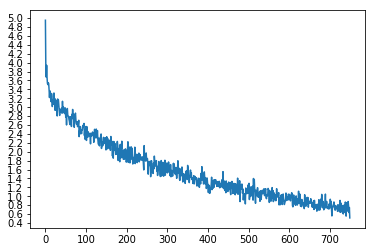

In [29]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1)


if use_cuda:
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [80]:
evaluateRandomly(encoder1, attn_decoder1)

> il est oceanographe.
= he s an oceanographer.
< hesoutgoing.<EOS>

> c est vous l enseignant.
= you re the teacher.
< youretheteacher.<EOS>

> vous etes des opportunistes.
= you re opportunistic.
< youreopportunistic.<EOS>

> je suis une nouvelle etudiante.
= i m a new student.
< imanewstudent.<EOS>

> elle est extremement seduisante.
= she is extremely attractive.
< sheistoocareful.<EOS>

> vous etes naive.
= you re naive.
< yourenaive.<EOS>

> je n y suis pas interessee.
= i m not interested in that.
< imnotreallyaboutthat.<EOS>

> je viens de tokyo.
= i m from tokyo.
< imfromfrance.<EOS>

> je suis attentive.
= i m attentive.
< imattentive.<EOS>

> vous etes completement ignorants.
= you re totally ignorant.
< youretotallyignorant.<EOS>



# Attention 시각화
어텐션 메커니즘의 유용한 속성은 해석 가능성이 높은 출력입니다. 입력 시퀀스의 특정 인코더 출력에 가중치를 부여하는 데 사용되므로 각 시간 단계에서 네트워크가 가장 집중되는 위치를 파악할 수 있습니다.

어텐션 출력을 행렬로 표시하기 위해 plt.matshow(attentions) 를 간단하게 실행할 수 있습니다. 열은 입력 단계와 행이 출력 단계입니다:

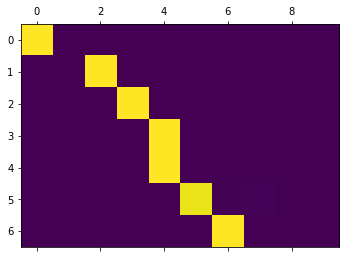

In [81]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

더 나은 보기 경험을 위해 축과 라벨을 추가하는 추가 작업을 수행합니다:

input = elle a cinq ans de moins que moi .
output = she s two years older than her <EOS>


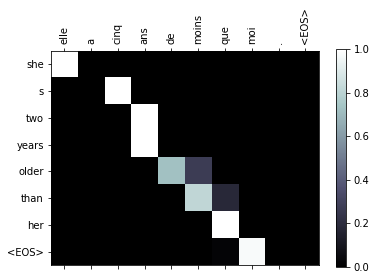

input = elle est trop petit .
output = she s too too fat. <EOS>


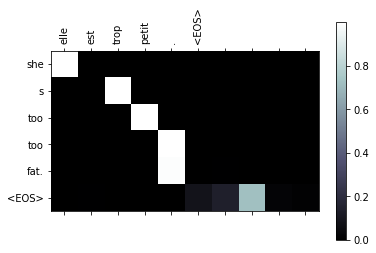

input = je ne crains pas de mourir .
output = i m not of of making out of <EOS>


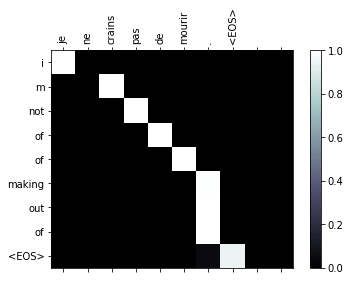

input = c est un jeune directeur plein de talent .
output = he s a promising young <EOS>


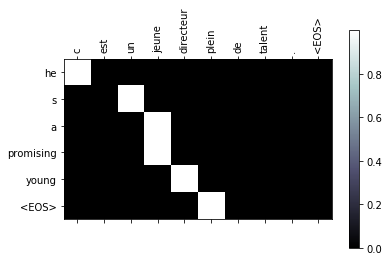

In [82]:
def showAttention(input_sentence, output_words, attentions):
    # colorbar로 그림 설정
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")